In [1]:
import pandas as pd
import re
import datetime

data = pd.read_csv("Hamilton_gross.csv")
data = data.drop(data.columns[0],axis=1)

data.columns = [name.lower().replace(" ", "_")
                for name in data.columns]
data.columns = [name.lower().replace("%", "")
                for name in data.columns]


data["date"] = [datetime.datetime.strptime(i, '%b %d, %Y') for i in data["date"]]
data["gross"] = [re.sub("[^\d]", "", i) for i in data["gross"]]
data["gross"] = [int(i) for i in data["gross"]]
data["_attendance"] = [i.replace(",","") for i in data["_attendance"]]
data["_attendance"] = [int(i) for i in data["_attendance"]]

data["gross_pot"] = [i.replace("%","") for i in data["gross_pot"]]
data["gross_pot"] = [float(i)/100 for i in data["gross_pot"]]
data["capacity"] = [i.replace("%","") for i in data["capacity"]]
data["capacity"] = [float(i)/100 for i in data["capacity"]]

data = data.sort("date")
data = data.set_index("date")

data.rename(columns={"_attendance":"attendance"}, inplace=True)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


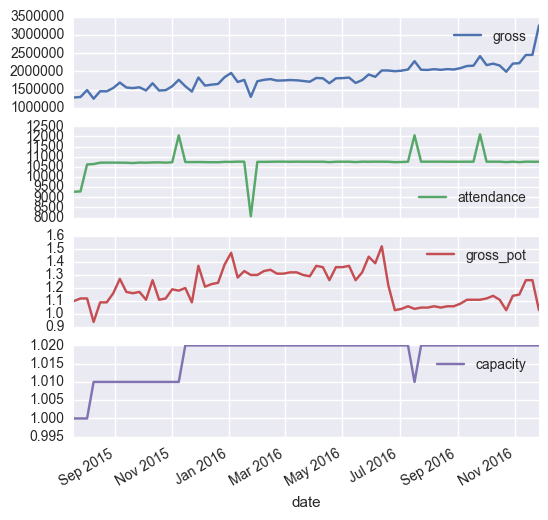

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = data[['gross', 'attendance', 'gross_pot', 'capacity']]

df.plot(subplots=True, figsize=(6, 6),x_compat=True);


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


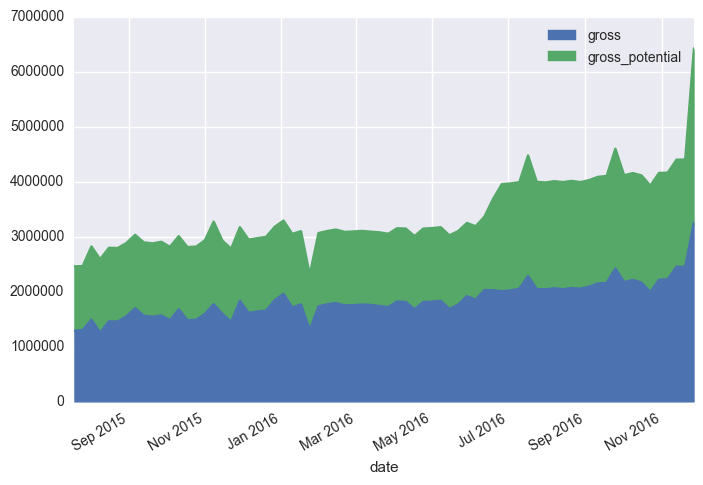

In [3]:
df2 = data[["gross"]]
#df2['gross'] = data["gross"]
df2["gross_potential"] = data["gross"]/data["gross_pot"]
df2.plot.area(x_compat=True)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


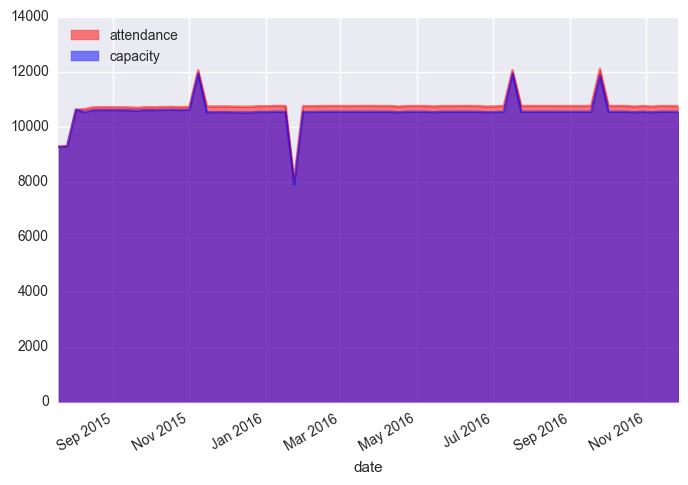

In [4]:
df3 = data[["attendance"]]
#df2['gross'] = data["gross"]
df3["capacity"] = data["attendance"]/data["capacity"]
df3.plot.area(x_compat=True,stacked=False,color=["red","blue"])

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


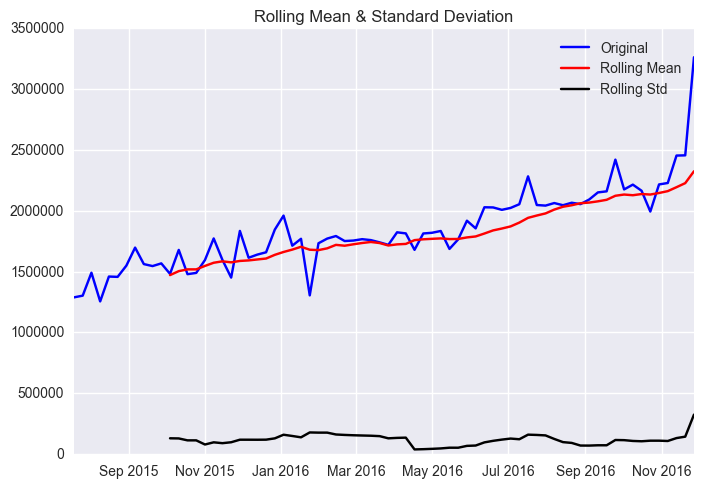

Results of Dickey-Fuller Test:
Test Statistic                  1.572242
p-value                         0.997772
#Lags Used                      8.000000
Number of Observations Used    63.000000
Critical Value (10%)           -2.591897
Critical Value (5%)            -2.908645
Critical Value (1%)            -3.538695
dtype: float64


In [6]:
test_stationarity(data["gross"])

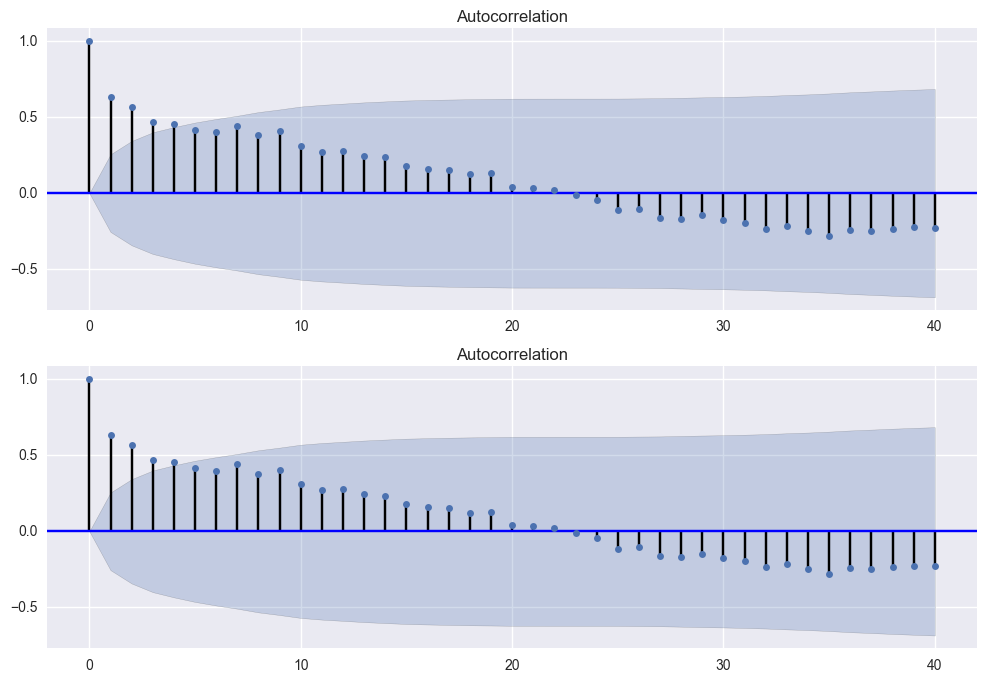

In [16]:
import statsmodels as sm
from statsmodels.graphics import tsaplots

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(df.gross.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_acf(df.gross.iloc[13:], lags=40, ax=ax2)


In [21]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.gross, order=(2, 1, 2))  
results_ARIMA = model.fit()  
plt.plot(df.gross)
plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

#mod = tsa.SARIMAX(df.gross, trend='n', order=(0,0,0), seasonal_order=(1,1,1,9))
#results = mod.fit()
#print (results.summary())

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)  
df[['gross', 'forecast']].plot(figsize=(12, 8))